# Processing GEM2 and magnaprobe data

**Adam Steer**

**May 2022**

From Magnaprobe and GEM2 measurements we get snow depth at about 1-2m along track resolotion, and combined snow + ice depth at some unknown resolution.

From these datasets, we need to generate snow depth (done!), ice thickness, draft and freeboard.

For ice thickness, draft and freeboard we rely on some assumptions about hydrostatic equilibrium and density of snow and ice. Using those, we model freeboard and draft using snow depths from the magnaprobe and combined snow and ice thickness from the GEM2 as constraints.

This notebook uses the approach:

- collect drift-corrected magnaprobe data into a set of point geometries
- collect drift-corrected GEM2 data into a set of point geometries
- test each magnaprobe point and find GEM2 data within 2.5 m radius (5m diameter)
- collect the median of GEM2 points found in that radius
- subtract magnaprobe snowdepth from median of GEM2 points
- use median GEM2 data, magnaprobe snow depth, and snow/ice density observations to compute ice thickness, draft and freeboard

This will result in a lot of overlapping data - for example two consecutive magnaprobe points are very likely to have overlap in their region where GEM2 data are collected. Given that GEM2 has a footprint of approximately 4 m diamter, this simple relfects the reality of how the measurements are collected. If needed, spatial filtering can be done later.


In [1]:
## import all the things we need

import os

import numpy as np

from scipy import stats

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['font.size'] =18
inches = 2.51

from shapely import geometry

import pyproj

# array functions, used to generate moving standard deviations
import bottleneck as bn


In [2]:
# declare a function to compute freeboard
def find_fi(zi, zs, dwater, dice, dsnow):
    
    #derived by Claire Trenham, CSIRO, and Adam Steer.
    fi = (((dwater - dice) * zi) - dsnow * zs) / dwater
    
    return fi

# A stats printing function
def printstats(inputdata):
    print("number of observations: {}".format(len(inputdata)))
    print("min: {}".format(np.nanmin(inputdata)))
    print("max: {}".format(np.nanmax(inputdata)))
    print("mean: {}".format(np.nanmean(inputdata)))
    print("median: {}".format(np.nanmedian(inputdata)))
    print("standard deviation: {}".format(np.nanstd(inputdata)))
    print("skewness: {}".format(stats.skew(inputdata)))
    

In [3]:
## set some phsyical properties, these are used to compute sea ice freeboard

# density of seawater
d_water = 1027

# density of sea ice
d_ice = 915

# density of snow
d_snow = 350

### Start loading MP data

In [4]:
mp_rawdata = pd.read_csv("/mnt/documents/JC2-2/P9-06092021/magnaprobe/jc2-2-P9-07092021-magnaprobe.csv",
                      skiprows = 10)

In [5]:
mp_rawdata

timestamp        easting       northing  snowdepth
0      22-01-2002T08:10:17.4  384342.577203 -299127.747128     1.2100
1     22-01-2002T08:10:19.45  384342.636087 -299127.600986     1.2100
2     22-01-2002T08:10:22.45  384342.396940 -299127.628420    -0.0001
3     22-01-2002T08:10:24.83  384342.460824 -299127.610583     1.2100
4     22-01-2002T08:10:25.85  384342.355037 -299127.565841     1.2100
...                      ...            ...            ...        ...
4062  22-01-2002T14:02:39.76  384341.703759 -299123.924696     0.0010
4063  22-01-2002T14:02:43.01  384344.076102 -299123.053290     0.0010
4064  22-01-2002T14:02:44.14  384345.161018 -299121.998018     0.0010
4065  22-01-2002T14:02:45.81  384345.919308 -299121.964330     0.0010
4066  22-01-2002T14:02:46.75  384346.659486 -299121.343219     0.0010

[4067 rows x 4 columns]

In [6]:
mp_data = mp_rawdata.loc[(mp_rawdata["snowdepth"] > 0) & (mp_rawdata["snowdepth"] < 1.2)]

In [7]:
# generate a list of tuple coordinate pairs
xypairs = list(zip(mp_data["easting"].values, mp_data["northing"].values))

In [8]:
xypairs[0]

(384355.2843185451, -299129.4469079537)

In [9]:
# make geometries from each point
mp_points = []

for pair in xypairs:
    mp_points.append(geometry.Point(pair[0], pair[1]))

In [10]:
# make buffered points, with 24 sided 'circles'

mp_buffers = []
for point in mp_points:
    mp_buffers.append(point.buffer(5, resolution=36))

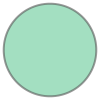

In [11]:
mp_buffers[0]

### Check distance between magnaprobe samples

get difference between array elements in X and Y coordinates, do some Pythagoras to get an idea of the magnaprobe observation step size.

This gives an approximate along-track ground sampling distance, useful for setting filtering windows later

In [12]:
stepX = np.diff(mp_data["easting"].values-5)
stepY = np.diff(mp_data["northing"].values)
mp_point2point = np.sqrt(stepX**2 + stepY**2)

In [13]:
printstats(mp_point2point)

number of observations: 4045
min: 0.03380924672725974
max: 18.12821938155348
mean: 1.0641928262437421
median: 0.9612026142598328
standard deviation: 0.5692935268918695
skewness: 8.32987181012052


## Read and geometry-ify GEM2 data

In [14]:
gem2_data_morning = pd.read_csv("/mnt/documents/JC2-2/P9-06092021/gem2/07092021/GEM2data-07092021-driftcorrected-morning.csv",
                      skiprows = 10)

In [15]:
gem2_data_afternoon = pd.read_csv("/mnt/documents/JC2-2/P9-06092021/gem2/07092021/GEM2data-07092021-driftcorrected-afternoon.csv",
                      skiprows = 10)

In [16]:
gem2_data_morning[0:5]

time   record_id        easting       northing   xc  \
0  2021-09-07T08:18:40.523437           2  384341.162213 -299129.541130  0.0   
1  2021-09-07T08:18:40.617187           3  384341.171105 -299129.549586  0.0   
2  2021-09-07T08:18:40.718750           4  384341.174017 -299129.551184  0.0   
3  2021-09-07T08:18:40.820312           5  384341.176902 -299129.552775  0.0   
4  2021-09-07T08:18:40.921875           6  384341.187853 -299129.561707  0.0   

    yc   f450Hz_hcp_i  f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
0  0.0          1.954         1.445           1.531           1.491   
1  0.0          0.849         1.422           1.567           1.501   
2  0.0          0.597         1.418           1.511           1.507   
3  0.0          0.903         1.464           1.557           1.505   
4  0.0          1.187         1.468           1.510           1.520   

    f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i   f18330Hz_hcp_q  \
0           1.504           1.494            1.501            1.497   
1           1.491           1.494            1.502            1.496   
2           1.514           1.496            1.503            1.495   
3           1.522           1.496            1.501            1.497   
4           1.513           1.503            1.501            1.498   

    f63030Hz_hcp_i  f63030Hz_hcp_q  
0            1.504           1.488  
1            1.504           1.490  
2            1.504           1.492  
3            1.504           1.491  
4            1.503           1.489

In [17]:
gem2_data_afternoon[0:5]

time   record_id        easting       northing   xc  \
0  2021-09-07T11:31:11.437500           7  384340.995131 -299129.809414  0.0   
1  2021-09-07T11:31:11.539062           8  384341.006103 -299129.818326  0.0   
2  2021-09-07T11:31:11.640625           9  384341.017066 -299129.827115  0.0   
3  2021-09-07T11:31:11.742187          10  384341.028041 -299129.835912  0.0   
4  2021-09-07T11:31:11.835937          11  384341.038162 -299129.844026  0.0   

    yc   f450Hz_hcp_i  f450Hz_hcp_q  f1530Hz_hcp_i  f1530Hz_hcp_q  \
0  0.0          1.885         1.554          1.596          1.518   
1  0.0          0.982         1.648          1.402          1.520   
2  0.0          1.717         1.566          1.447          1.485   
3  0.0          2.112         1.459          1.602          1.483   
4  0.0          2.045         1.502          1.631          1.496   

   f5310Hz_hcp_i  f5310Hz_hcp_q  f18330Hz_hcp_i  f18330Hz_hcp_q  \
0          1.504          1.499           1.507           1.488   
1          1.516          1.503           1.505           1.491   
2          1.528          1.503           1.505           1.495   
3          1.534          1.501           1.505           1.496   
4          1.543          1.502           1.504           1.496   

   f63030Hz_hcp_i  f63030Hz_hcp_q  
0           1.501           1.484  
1           1.501           1.486  
2           1.501           1.487  
3           1.500           1.488  
4           1.500           1.489

In [18]:
gem2_data_morning.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

### check distance between GEM2 samples

This gives an approximate along-track ground sampling distance, useful for setting filtering windows later

In [19]:
stepX = np.diff(gem2_data_morning["easting"].values)
stepY = np.diff(gem2_data_morning["northing"].values)

gem2_point2point = np.sqrt(stepX**2 + stepY**2)

In [20]:
printstats(gem2_point2point)

number of observations: 17567
min: 0.0008108418399627806
max: 5.1064983581746075
mean: 0.0828108374978395
median: 0.08520371812100466
standard deviation: 0.058383986876110835
skewness: 56.04284437436857


In [21]:
stepX = np.diff(gem2_data_afternoon["easting"].values)
stepY = np.diff(gem2_data_afternoon["northing"].values)

gem2_point2point = np.sqrt(stepX**2 + stepY**2)

In [22]:
printstats(gem2_point2point)

number of observations: 31052
min: 3.068713905266946e-05
max: 4.372520813048916
mean: 0.08297053070466308
median: 0.08429242215133942
standard deviation: 0.06308283307139345
skewness: 39.18781258682107


## Check that GEM2 and Magnaprobe coordinates line up!

Here, we can add a manual XY offset (translation) to line GEM2 and magnaprobe coordinates up as closely as possible. 

Circular windows around each Magnaprobe point are also shown, to get an idea of where we will find spatially-matched data.

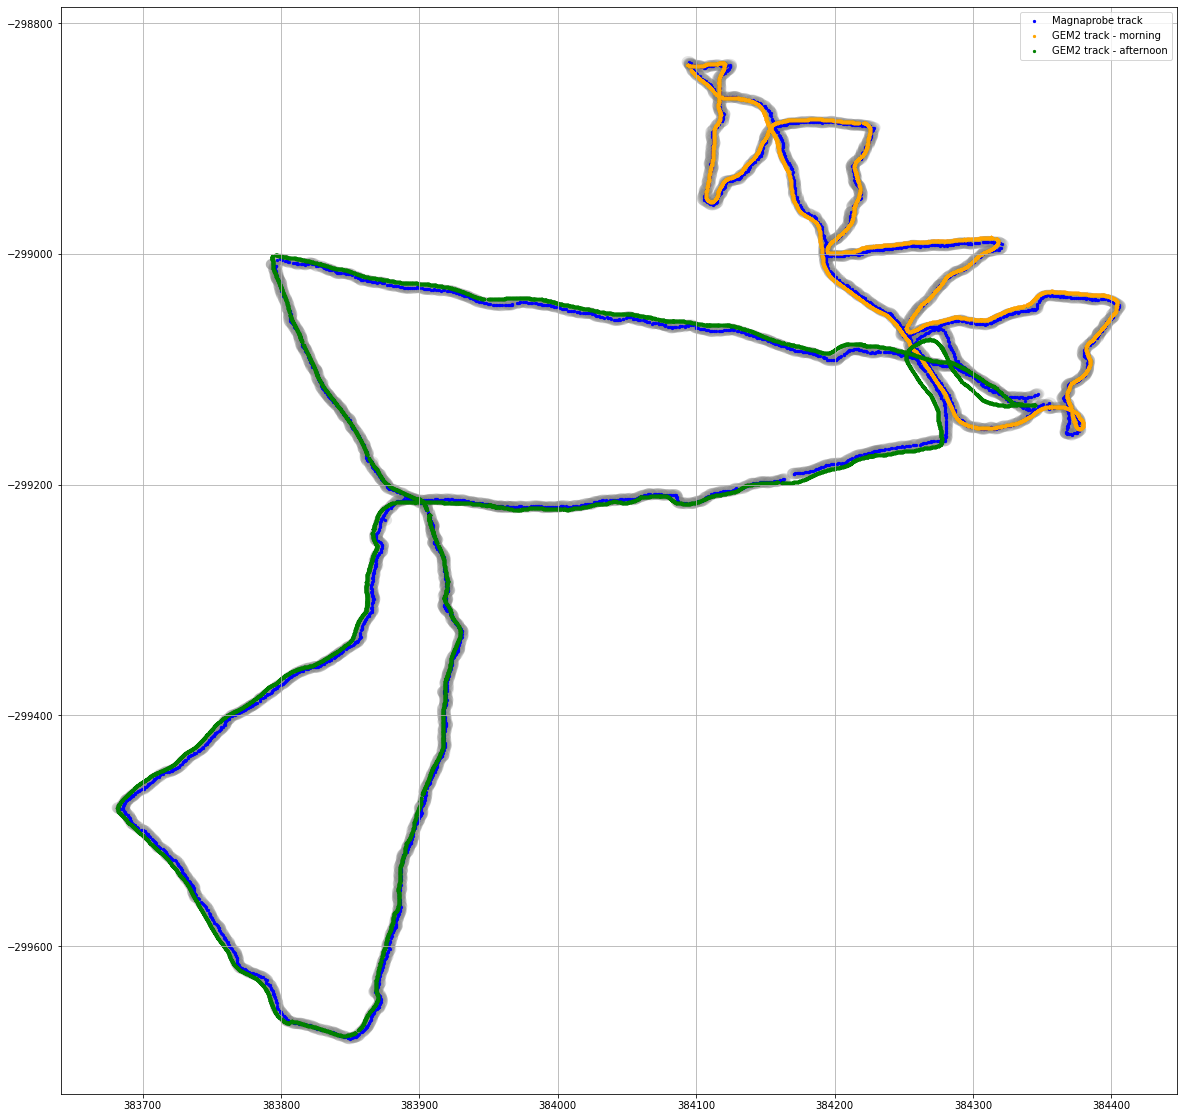

In [23]:
fig = plt.figure(figsize=(20,20))

for dot in mp_buffers:    
    xs, ys = dot.boundary.xy    
    plt.fill(xs, ys, alpha=0.2, fc='grey', ec='none')

plt.scatter(mp_data["easting"].values, mp_data["northing"].values, s=5,
            c='Blue', label = "Magnaprobe track")
plt.scatter(gem2_data_morning["easting"].values+16, gem2_data_morning["northing"].values-3,
            c = 'Orange', label = "GEM2 track - morning", s=5)
plt.scatter(gem2_data_afternoon["easting"].values+3.5, gem2_data_afternoon["northing"].values-1.5,
            c = 'Green', label = "GEM2 track - afternoon", s=5)


plt.legend()
plt.grid()

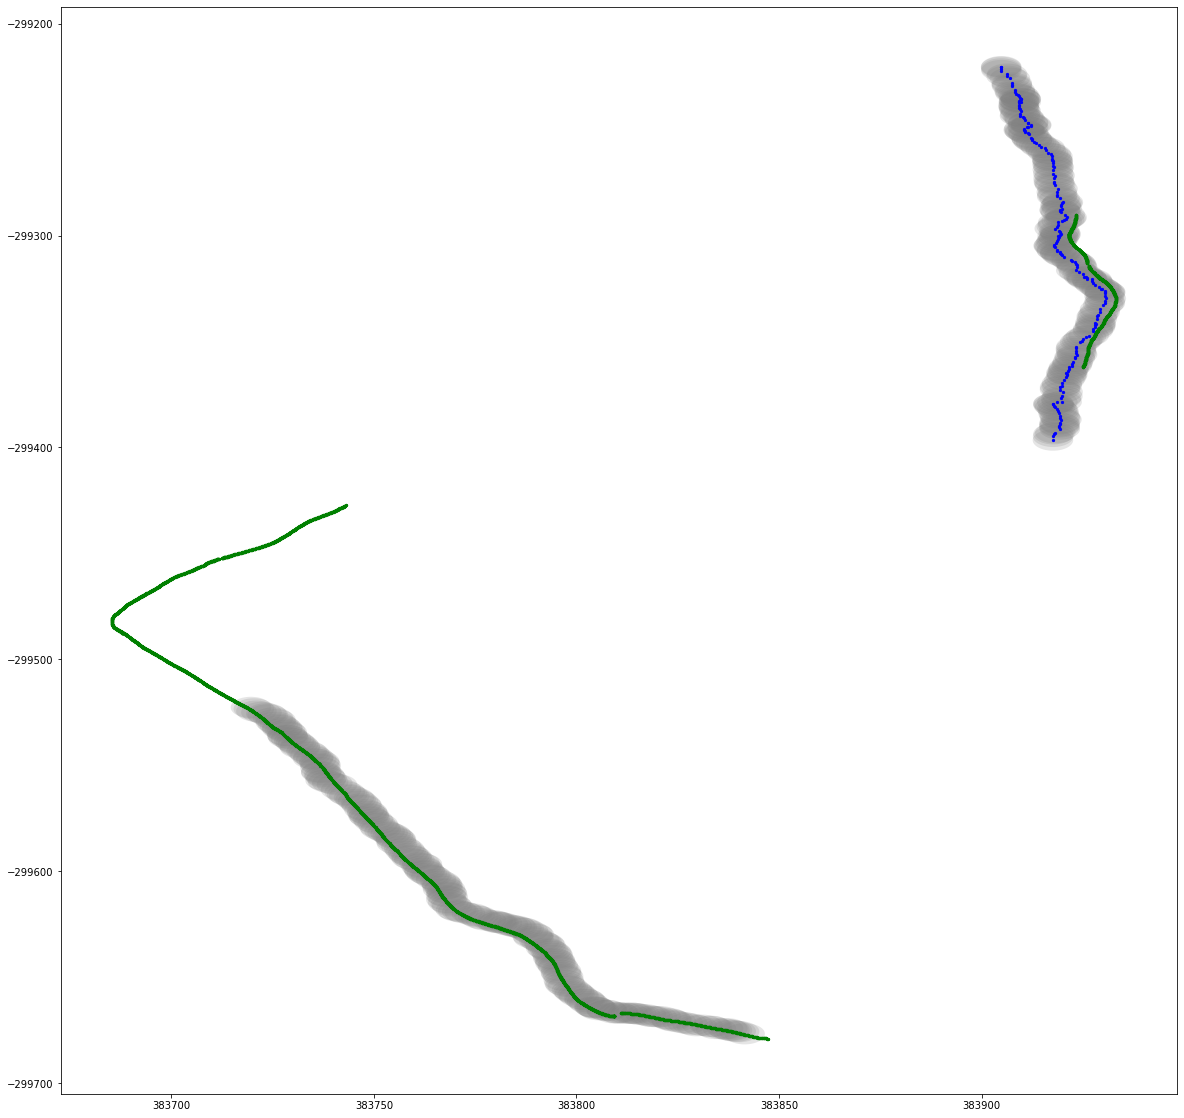

In [24]:
fig = plt.figure(figsize=(20,20))

for dot in mp_buffers[2300:2500]:    
    xs, ys = dot.boundary.xy    
    plt.fill(xs, ys, alpha=0.2, fc='grey', ec='none')

for dot in mp_buffers[2800:3000]:    
    xs, ys = dot.boundary.xy    
    plt.fill(xs, ys, alpha=0.2, fc='grey', ec='none')

plt.scatter(mp_data["easting"].values[2300:2500], mp_data["northing"].values[2300:2500], s=5,
            c='Blue', label = "Magnaprobe track")

plt.scatter(gem2_data_afternoon["easting"].values[11000:12000]+7,
            gem2_data_afternoon["northing"].values[11000:12000]-3,
            c = 'Green', label = "GEM2 track - afternoon", s=5)

plt.scatter(gem2_data_afternoon["easting"].values[16000:20000]+7,
            gem2_data_afternoon["northing"].values[16000:20000]-3,
            c = 'Green', label = "GEM2 track - afternoon", s=5)


Next, add the offsets we needed to align data to the data themselves...

In [25]:
# Add offsets we derived in the plot above

gem2_morning_xypairs = list(zip(gem2_data_morning["easting"].values+16,
                                gem2_data_morning["northing"].values-3))


In [26]:
gem2_afternoon_xypairs = (list(zip(gem2_data_afternoon["easting"].values+6.5, 
                                   gem2_data_afternoon["northing"].values-4)))

In [27]:
gem2_xypairs = gem2_morning_xypairs
gem2_xypairs.extend(gem2_afternoon_xypairs)

In [28]:
len(gem2_xypairs)

48621

In [29]:
len(gem2_data_afternoon["easting"].values)

31053

In [30]:
# make geometries from each point
gem2_points = []

for pair in gem2_xypairs:
    gem2_points.append(geometry.Point(pair[0], pair[1]))

In [31]:
# hmm. we have to append a lot of datasets also...

gem2data = gem2_data_morning.copy()

In [32]:
gem2_data = pd.concat([gem2_data_morning,gem2_data_afternoon])

## Select GEM2 data points to use

- find GEM2 points within the buffer from MP points
- collect GEM2 observations matching those points
- compute the median of GEM2 observations
- assemble an array of MP and matching median GEM2 observations

In [33]:
%%time 

mp_ind = 0
gem2_ind = 0
bufferpoints = []
collected_points = []

# iterate over MP buffers
for buffer in mp_buffers:
    #print("buffer {}".format(mp_ind))
    #then over gem2 points - the whole array
    for thispoint in gem2_points:
        
        #if the buffer contains the point
        if buffer.contains(thispoint):
            
            #capture the index of each point the buffer contains
            bufferpoints.append(gem2_ind)
        
        # increment the index counter
        gem2_ind += 1
    #reset the gem2 index
    gem2_ind = 0
    
    #add the array of GEM2 indexes to the list
    collected_points.append([mp_ind, bufferpoints])

    #reset GEM2 index list
    bufferpoints = []
    mp_ind += 1

CPU times: user 4min 39s, sys: 36 ms, total: 4min 39s
Wall time: 4min 39s


In [34]:
#see whats in the collected points array - for a non-empty point

np.array(collected_points[10][1])

array([  104,   105,   106,   107,   108,   109,   110,   111,   112,
         113,   114,   115,   116,   117,   118,   119,   120,   121,
         122,   123,   124,   125,   126,   127,   128,   129,   130,
         131,   132,   133,   134,   135,   136,   137,   138,   139,
         140,   141,   142,   143,   144,   145,   146,   147,   148,
         149,   150,   151,   152,   153,   154,   155,   156,   157,
         158,   159,   160,   161,   162,   163,   164,   165,   166,
         167,   168,   169,   170,   171,   172,   173,   174,   175,
         176,   177,   178,   179,   180,   181,   182,   183,   184,
         185,   186,   187,   188,   189,   190,   191,   192,   193,
         194,   195,   196, 17568, 17569, 17570, 17571, 17572, 17573,
       17574, 17575, 17576, 17577, 17578, 17579, 17580, 17581, 17582,
       17583, 17584, 17585, 17586, 17587, 17588, 17589, 17590, 17591,
       17592, 17593, 17594, 17595, 17596, 17597, 17598, 17599, 17600,
       17601, 17602,

In [35]:
the_nhood = gem2_data[" f5310Hz_hcp_i"].values[np.array(collected_points[10][1])]

In [36]:
the_nhood = [float(x) for x in the_nhood]

In [37]:
np.median(np.array(the_nhood))

1.563

In [38]:
#generate a list of MP data indexes and GEM2 median measurements
median_gem2 = []

for datapoint in collected_points:
    if len(datapoint[1]) > 0:
        #oof. extra lines to deal with the case of weird mixed types.
        the_nhood = np.array(gem2_data[" f5310Hz_hcp_i"].values[datapoint[1]])
        the_nhood = [float(x) for x in the_nhood]
        
        #ok now we can do maths
        thismedian = np.median(the_nhood)

    else:
        thismedian = np.nan
        
    the_array = [datapoint[0], thismedian]
    median_gem2.append(the_array)

In [39]:
# inspect the array
median_gem2[0:5]

[[0, 1.547],
 [1, 1.555],
 [2, 1.553],
 [3, 1.5539999999999998],
 [4, 1.5379999999999998]]

In [40]:
# this sets up an array of one GEM2 observation per Magnaprobe observation,
# using the median of GEM2 observations within some radius of the Magnaprobe observation

gem2_zi = [pair[1] for pair in median_gem2]

## Compute ice thickness, freeboard, draft

Now that we have separate ice and snow components, we can estimate freeboard and draft also!

#### Ice thickness

In [41]:
# Now, to get the ice thickness (zi) component of the GEM2 signal, we subtract the Magnaprobe observed snow depth
# ay each point
zi = gem2_zi - mp_data["snowdepth"].values

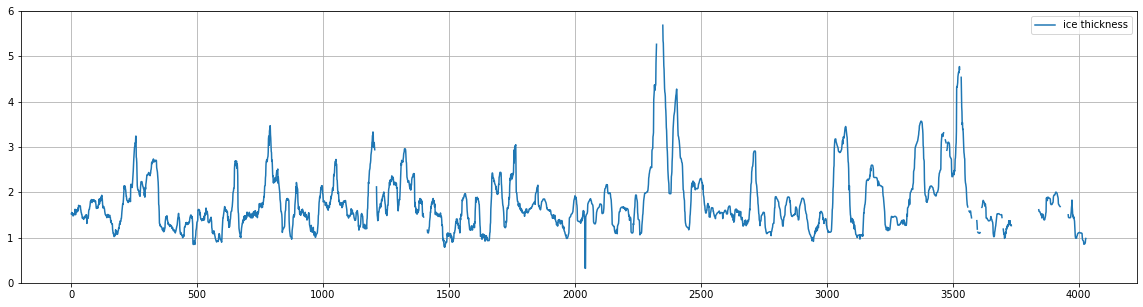

In [42]:
# quick ice thickness plot.
# note any negative values likely come from a data point in the Magnaprobe dataset which should be cleaned out 

fig = plt.figure(figsize=(20,5))

plt.plot(zi, label = "ice thickness")
plt.ylim(0, 6)
plt.legend()
plt.grid()

In [43]:
# show some basic stats
printstats(zi)

number of observations: 4046
min: 0.3195000000000001
max: 5.686
mean: 1.7575784696569923
median: 1.5943699999999998
standard deviation: 0.6307163068446194
skewness: nan


#### Ice freeboard

In [44]:
# Feed ice, snow, and density numbers into our hydrostatic model to estimate sea ice freeboard
#(zi, zs, dwater, dice, dsnow)
freeboards = find_fi(zi,mp_data["snowdepth"].values, d_water, d_ice, d_snow)

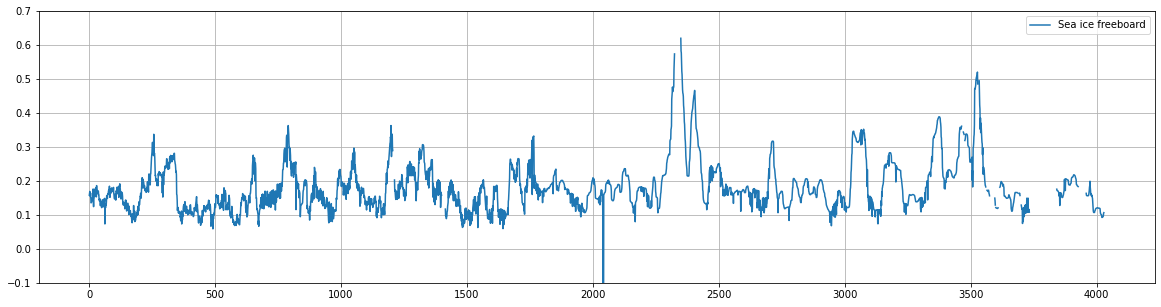

In [45]:
fig = plt.figure(figsize=(20,5))

plt.plot(freeboards, label = "Sea ice freeboard")
plt.ylim(-0.1, 0.7)
plt.legend()
plt.grid()

In [46]:
printstats(freeboards)

number of observations: 4046
min: -0.3499182083739046
max: 0.6197487828627068
mean: 0.18054773716514272
median: 0.16708815968841287
standard deviation: 0.07291247244748492
skewness: nan


#### Ice draft

In [47]:
drafts = freeboards - zi

(-6.0, 0.0)

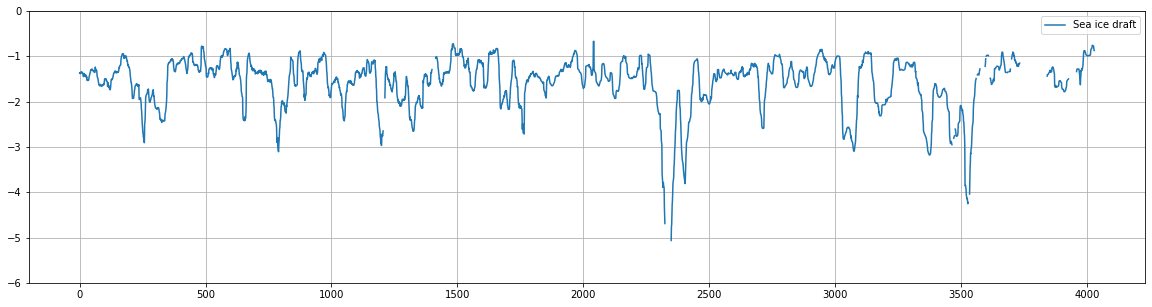

In [48]:
fig = plt.figure(figsize=(20,5))

plt.plot(drafts, label = "Sea ice draft")
plt.legend()
plt.grid()
plt.ylim(-6,0)

In [49]:
printstats(drafts)

number of observations: 4046
min: -5.066251217137293
max: -0.6694182083739046
mean: -1.5770307324918496
median: -1.4316601265822786
standard deviation: 0.5600447776855747
skewness: nan


#### Sea ice surface elevation

What we see at the top - snow depth plus freeboard

In [50]:
elevation = freeboards + mp_data["snowdepth"].values

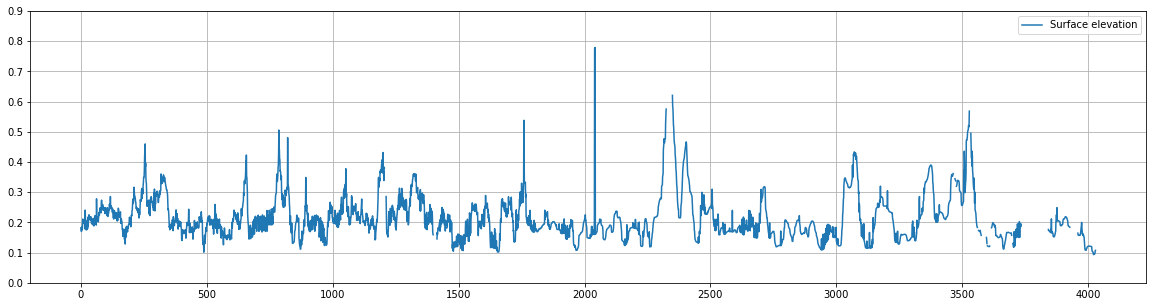

In [51]:
fig = plt.figure(figsize=(20,5))

plt.plot(elevation, label = "Surface elevation")
plt.ylim(0, 0.9)
plt.legend()
plt.grid()

In [52]:
printstats(elevation)

number of observations: 4046
min: 0.09346543330087634
max: 0.7790817916260955
mean: 0.21319420154508995
median: 0.19880817916260957
standard deviation: 0.07243381881913141
skewness: nan


#### Snow depth

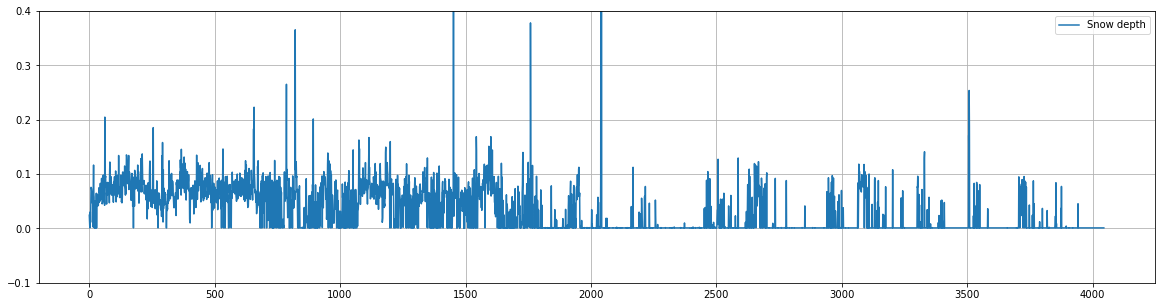

In [53]:
fig = plt.figure(figsize=(20,5))

plt.plot(mp_data["snowdepth"].values,label = "Snow depth")
plt.ylim(-0.1, 0.4)
plt.legend()
plt.grid()

In [54]:
printstats(mp_data["snowdepth"].values)

number of observations: 4046
min: 0.0004
max: 1.151
mean: 0.03127088235294117
median: 0.001
standard deviation: 0.05206700341458963
skewness: 9.840920215873682


### Estimate surface and under-ice roughness

Collect a proxy for roughness - the standard deviation of elevation (and draft) within an approximate 5 m sliding window

In [55]:
## surface roughness. Because step size is about 0.8m, we use a window size of 6 - approx. 4.m along track

elevation_roughness = bn.move_std(elevation, window=6)


In [56]:
## draft roughness, same window size

draft_roughness = bn.move_std(drafts, window=6)

## Plot all the things together

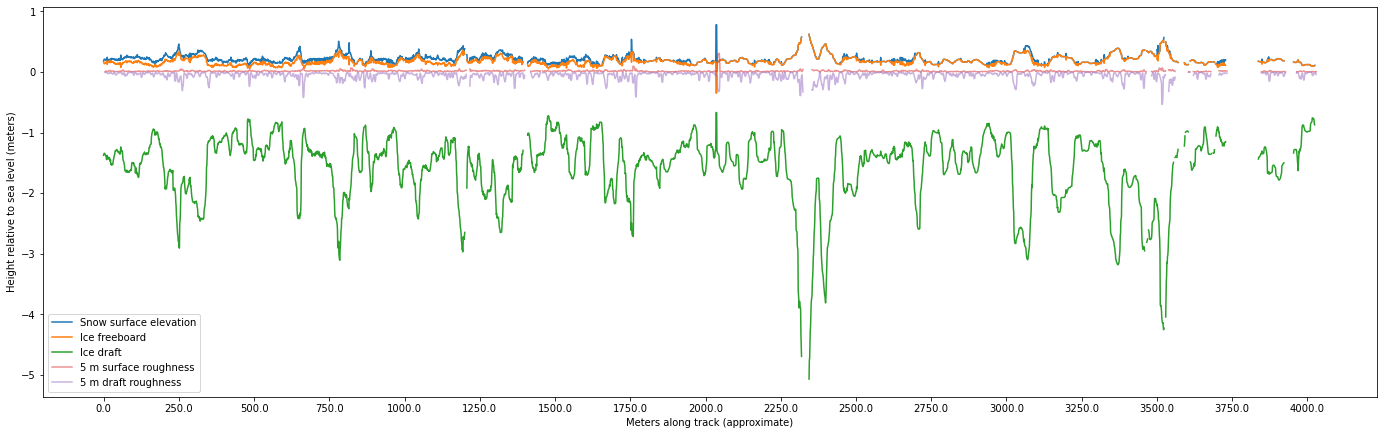

In [57]:
fig = plt.figure(figsize=(60/inches,18/inches))

plt.plot(freeboards[5:-5] + mp_data["snowdepth"].values[5:-5], label = "Snow surface elevation")
plt.plot(freeboards[5:-5], label = "Ice freeboard")
plt.plot(drafts[5:-5], label = "Ice draft")

## roughnesses are offset a little, just so they're visible
plt.plot(np.array(elevation_roughness), label = "5 m surface roughness", alpha = 0.5)

plt.plot((0-draft_roughness), label = "5 m draft roughness", alpha = 0.5)



plt.legend()
ax = plt.gca()

thenumbers = np.arange(0, len(drafts),250)
xticks_meters = [x * np.median(mp_point2point) for x in thenumbers]

plt.xticks(thenumbers,xticks_meters)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_xlabel("Meters along track (approximate)")
ax.set_ylabel("Height relative to sea level (meters)")

plt.savefig("/mnt/documents/JC2-2/P9-06092021/alongtrack-snowandice.png")

## Because we all love a histogram...

...and histograms give us some information about distributions, here are a few hopefully useful ones.

In [58]:
icebins = np.arange(0, np.nanmax(zi[5:-5]), 0.05)
snowbins = np.arange(0, 0.5, 0.005)

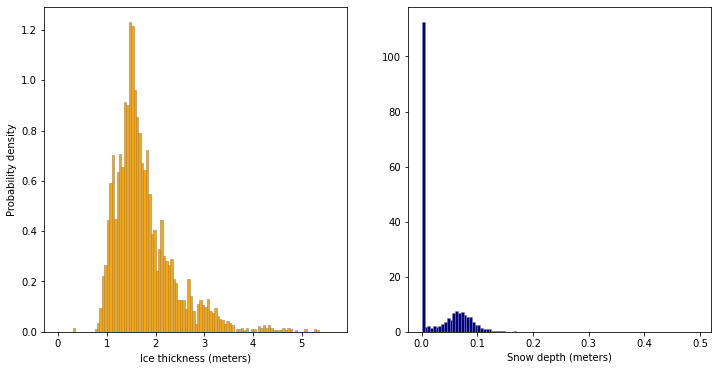

In [59]:
fig = plt.figure(figsize = (30/inches,15/inches))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(zi, icebins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'ice thickness',
                            density = True)


day1snowhist, snowx, _ = ax2.hist(mp_data["snowdepth"].values, snowbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'snow depth', density = True)


ax1.set_xlabel("Ice thickness (meters)")
ax1.set_ylabel("Probability density")
ax2.set_xlabel("Snow depth (meters)")

plt.savefig("/mnt/documents/Q2/AeNP4-05052021/transect/AeNQ2-2021-P4-zi-zs-2panelhistogram.png")

(0.0, 4.0)

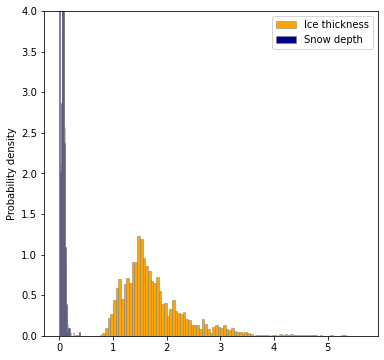

In [60]:
fig = plt.figure(figsize = (15/inches,15/inches))

ax1 = fig.add_subplot(111)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(zi[5:-5], icebins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'Ice thickness',
                             density = True)


day1snowhist, snowx, _ = ax1.hist(mp_data["snowdepth"].values, snowbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'Snow depth', density = True)


#ax1.set_xlabel("GEM2 ice thickness (meters)")
ax1.set_ylabel("Probability density")
#ax2.set_xlabel("Magnaprobe snow depth (meters)")

plt.legend()

plt.savefig("/mnt/documents/JC2-2/P9-06092021/AeN-JC2-2-2021-P9-zi-zs-onepanelhistogram.png")
plt.ylim(0,4)

In [61]:
fb_bins = np.arange(0, np.nanmax(freeboards), 0.005)
elevbins = np.arange(0, 1, 0.01)

Text(0.5, 0, 'Elevation')

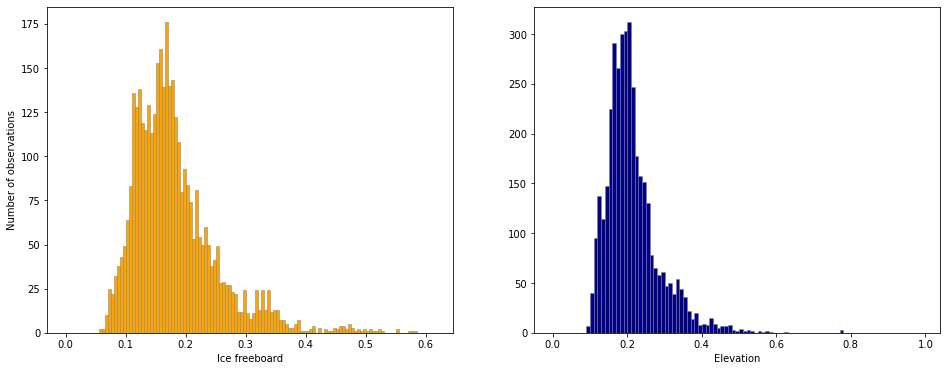

In [62]:
fig = plt.figure(figsize = (16,6))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(freeboards, fb_bins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'Freeboard')


day1snowhist, snowx, _ = ax2.hist(elevation, elevbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'Elevation')


ax1.set_xlabel("Ice freeboard")
ax1.set_ylabel("Number of observations")
ax2.set_xlabel("Elevation")

In [63]:
elev_roughness_bins = np.arange(0, np.nanmax(elevation_roughness), 0.005)
draft_roughness_bins = np.arange(0, np.nanmax(draft_roughness), 0.005)


Text(0.5, 0, 'Draft roughness')

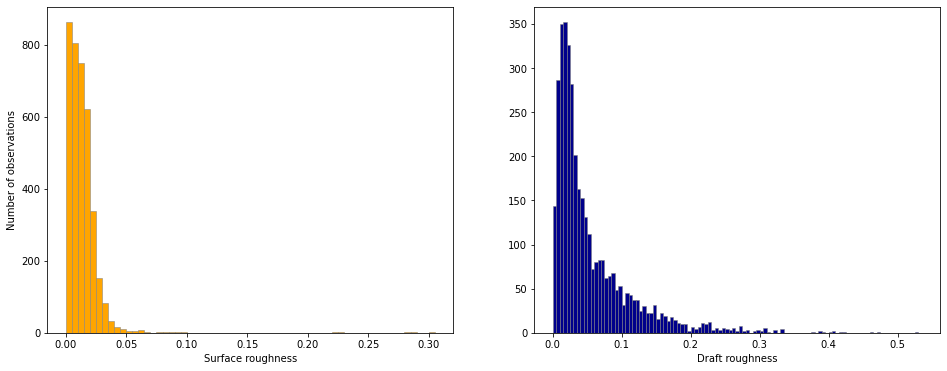

In [64]:
fig = plt.figure(figsize = (16,6))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(elevation_roughness, elev_roughness_bins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = '5 m surface roughness')


day1snowhist, snowx, _ = ax2.hist(draft_roughness, draft_roughness_bins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = '5 m draft roughness')


ax1.set_xlabel("Surface roughness")
ax1.set_ylabel("Number of observations")
ax2.set_xlabel("Draft roughness")

Text(0, 0.5, 'surface elevation')

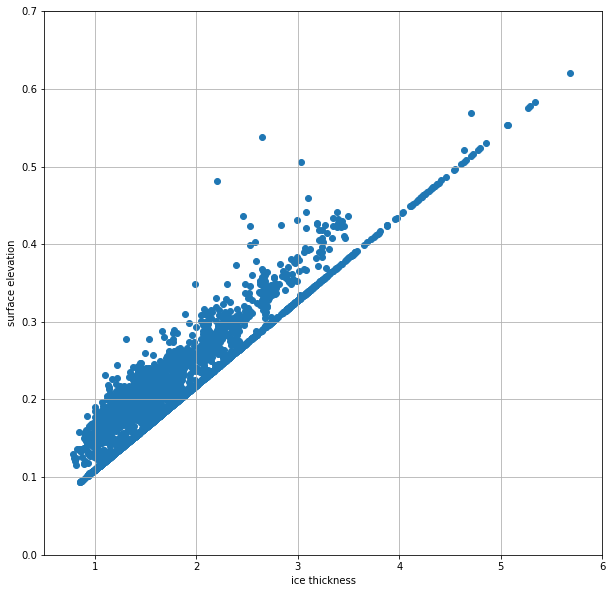

In [65]:
fig = plt.figure(figsize=(10,10))
plt.scatter(zi, elevation)
plt.xlim(0.5, 6)
plt.ylim(0,0.7)
plt.grid()
plt.xlabel("ice thickness")
plt.ylabel("surface elevation")


In [66]:
# from: https://localcoder.org/pearson-correlation-and-nan-values

bad = ~np.logical_or(np.isnan(elevation), np.isnan(zi))

elevs_for_r = np.compress(bad, elevation)
zi_for_r = np.compress(bad, zi)

In [67]:
stats.spearmanr(elevation, zi, nan_policy = "omit")

SpearmanrResult(correlation=0.8579334206727759, pvalue=0.0)

## map of ice thickness values

Visualising how many matches we got between MP and GEM2 data

In [68]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

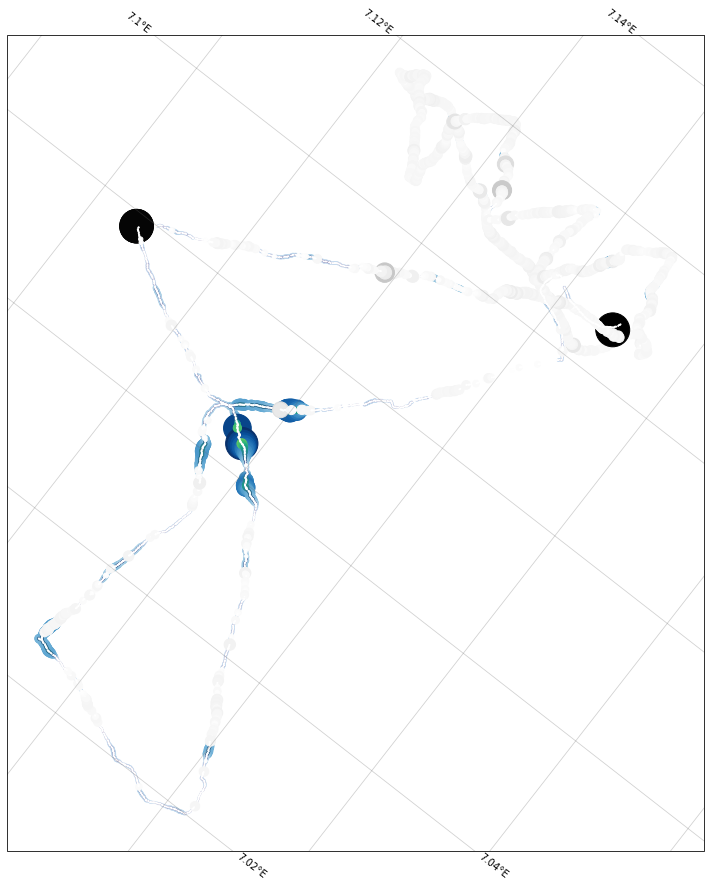

In [69]:
fig = plt.figure(figsize=(15,15))

mapproj = ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 )

ax = plt.axes(projection= mapproj)


plt.scatter(mp_data["easting"].values, mp_data["northing"].values, c=zi, s = (zi)**4,
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ),
           label = "Ice thickness", cmap="Blues")

plt.scatter(mp_data["easting"].values, mp_data["northing"].values,
           c=elevation, s = (5 * elevation)**4, cmap="viridis",
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ),
           label = "Ice thickness")


plt.scatter(mp_data["easting"].values, mp_data["northing"].values,
           c=mp_data["snowdepth"].values, s = (1000*mp_data["snowdepth"].values), cmap="Greys",
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ),
           label = "Ice thickness")
#cbar = plt.colorbar()
#cbar.set_label("Ice thickness")
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels = False
#gl.right_labels = False

showgridlines = ax.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True, x_inline = False)


In [70]:
## Maybe we could filter out too-close obs here... less than 0.4 / 40 cm?

In [71]:
len(mp_data["northing"].values)

4046

In [72]:
len(mp_point2point)

4045

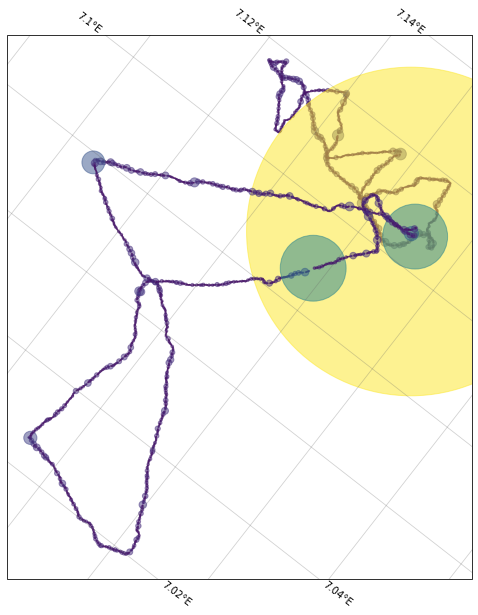

In [73]:
fig = plt.figure(figsize=(10,10))

mapproj = ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 )

ax = plt.axes(projection= mapproj)


plt.scatter(mp_data["easting"].values[1:], mp_data["northing"].values[1:], c= mp_point2point, s= mp_point2point**4, alpha=0.5,
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ))
#cbar = plt.colorbar()
#cbar.set_label("Ice thickness")
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels = False
#gl.right_labels = False

showgridlines = ax.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True, x_inline = False)

In [74]:
mp_data.keys()

Index(['timestamp', 'easting', 'northing', 'snowdepth'], dtype='object')

In [75]:
mp_data["northing"]

5      -299129.446908
6      -299131.174602
7      -299130.887102
8      -299131.140497
9      -299130.624113
            ...      
4062   -299123.924696
4063   -299123.053290
4064   -299121.998018
4065   -299121.964330
4066   -299121.343219
Name: northing, Length: 4046, dtype: float64

In [76]:
mp_data["easting"]

5       384355.284319
6       384353.768402
7       384353.417590
8       384353.309665
9       384350.548647
            ...      
4062    384341.703759
4063    384344.076102
4064    384345.161018
4065    384345.919308
4066    384346.659486
Name: easting, Length: 4046, dtype: float64

In [77]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)
latlon = backtolatlon.transform( mp_data["northing"].values,mp_data["easting"].values,)

In [78]:
len(latlon[0])

4046

In [79]:
len(drafts)

4046

In [80]:
latlon[0]

array([85.50621374, 85.50621498, 85.50621916, ..., 85.50632955,
       85.50632422, 85.50632236])

In [81]:
180-latlon[1]

array([7.10770276, 7.10743284, 7.10743418, ..., 7.10766287, 7.10772079,
       7.10783193])

In [82]:
zi_export = pd.DataFrame({"timestamp": mp_data["timestamp"].values,
                          "easting": mp_data["easting"].values,
                          "northing": mp_data["northing"].values,
                          "latitude": latlon[0],
                          "longitude": 180-latlon[1],
                          "snowdepth": mp_data["snowdepth"].values,
                          "ice_freeboard": freeboards,
                          "ice_thickness": zi,
                          "surface_elevation": elevation,
                          "ice_draft": drafts,
                          "5m_surface_roughness": elevation_roughness,
                          "5m_draft_roughness": draft_roughness})

In [83]:
header = """
Snow depth and ice thickness data from AeN JC2-2, P9
7 September 2021
Adam Steer, Anca Cristea
GEM2 data processed using libraries supplied by Stefan Hendricks
Drift correction and data alignment here: https://gitlab.com/adamsteer/aen/
Units are meters
Eastings and northings are EPSG:3413, NSIDC north polar stereographic



"""

In [84]:
outputfile = "/mnt/documents/JC2-2/P9-06092021/AenJC2-2-P9-transect-zi-zs-fb.csv"

In [85]:
with open(outputfile, 'w') as outfile:
    outfile.write(header)
    
zi_export.to_csv(outputfile, index=False, mode='a')

## Some main coring site stats

In [86]:
maincore = pd.read_csv("/mnt/documents/JC2-2/P9-06092021/main-site/JC2-2-P9_ICETEAM-NOTES_MM.csv", skiprows=5)

In [87]:
maincore[0:5]

Prio #core                  Core name    Requested by  \
0   1.0     1                Chemistry 1  Melissa,Agneta   
1   1.0     1  Chemistry 2 (Temperature)  Melissa,Agneta   
2   1.0     3            Physics core 1       Adam (RF1)   
3   1.0     4             Physics core 2      Adam (RF1)   
4   1.0     5             Physics core 3      Adam (RF1)   

   Ice gauge set off (cm) core length (cm) ice thickness (cm)  \
0                     NaN            190.0              183.0   
1                     NaN            184.0              183.0   
2                     0.5            173.0              170.0   
3                     0.5            170.0              167.0   
4                     0.5            178.0              173.0   

  Ice-water interface (cm) freeboard (cm) snow depth 1 (cm)  ...  \
0                    160.0           23.0               4.5  ...   
1                    169.0           14.0               4.0  ...   
2                    148.0           22.0               4.0  ...   
3                    146.0           21.0               7.0  ...   
4                    149.0           24.0               4.0  ...   

  snow depth 3 (cm)                                            COMMENT  \
0               7.0                                                NaN   
1               4.5                                   Temperature core   
2               7.0  part 1 109cm breaks at 42cm, part 2 complete 6...   
3               4.0  part 1 91 cm breaks at 11, 42. part 2 79 cm co...   
4               4.0  part 1 97cm breaks at 40. part 2 81cm break at 48   

  Section (cm)                      Section horizons Pooling  \
0    Full core                    0-10;10-20;20-30;…    None   
1    Full core  0-2.5;2.5-12.5;12.5-22.5;22.5-32.5;…    None   
2    Full core                           Entire core    none   
3    Full core                 0-5; 5-10; 10-15; etc    none   
4    Full core                           Entire core    none   

                                         Parameter  \
0               DIC/pH/Alk/dO18/nutrients/salinity   
1                     Temperature/backup chemistry   
2                                     Stratigraphy   
3  Salinity, d18O (0-20), (and cDOM not routinely)   
4                        Density core (9 cm corer)   

                                           Remarks  \
0                      Bagged whole, taken onboard   
1  Measured on ice and bagged whole, taken onboard   
2                      Bagged whole, taken onboard   
3                      Bagged whole, taken onboard   
4                      Bagged whole, taken onboard   

                    FSW?/Processing DARK?             comment  
0  no, sectioned and melted onboard   yes         + chemistry  
1                no, measure on ice   yes         + chemistry  
2                   freeze complete    no  Standard parameter  
3                   freeze complete    no                 NaN  
4                   freeze complete    no                 NaN  

[5 rows x 21 columns]

In [88]:
icemain = []
for x in maincore["ice thickness (cm)"]:
    try:
        icemain.append(float(x))
    except:
        pass

In [89]:
printstats(np.array(icemain)/100)

number of observations: 37
min: 1.56
max: 1.83
mean: 1.7461290322580647
median: 1.75
standard deviation: 0.06214849124137776
skewness: nan


In [90]:
printstats(zi[5:-5])

number of observations: 4036
min: 0.3195000000000001
max: 5.686
mean: 1.7578778044914134
median: 1.5955000000000001
standard deviation: 0.6310787036721713
skewness: nan


In [91]:
snow1 = []
for x in maincore["snow depth 1 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass
    

for x in maincore["snow depth 2 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass
    
for x in maincore["snow depth 3 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass

In [92]:
printstats(np.array(snow1)/100)

number of observations: 111
min: 0.03
max: 0.15
mean: 0.059895833333333336
median: 0.055
standard deviation: 0.01996062747775118
skewness: nan


In [93]:
printstats(mp_data["snowdepth"].values[5:-5])

number of observations: 4036
min: 0.0004
max: 1.151
mean: 0.03132430624380574
median: 0.001
standard deviation: 0.05211733066969339
skewness: 9.833978866343337
